# Example
A simple demonstration of how `dfcosmic` can be used to remove cosmic rays.

We will first make a sample clean image containing two fake elliptical galaxies and 10 stars. Then, we will make a fake cosmic ray mask with 10 cosmic rays and combine the clean image with the cosmic rays to make a dirty image. Finally, we will apply `dfcosmic` to remove the cosmic rays.

In [4]:
import numpy as np
from dfcosmic import lacosmic
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

In [5]:
def make_2d_rotated_gaussian(shape, amplitude, x0, y0, sigma_x, sigma_y, theta):
    """Create a 2D elliptical Gaussian with rotation"""
    y, x = np.ogrid[:shape[0], :shape[1]]
    x = x - x0
    y = y - y0

    x_rot = x * np.cos(theta) + y * np.sin(theta)
    y_rot = -x * np.sin(theta) + y * np.cos(theta)

    return amplitude * np.exp(
        -(x_rot ** 2 / (2 * sigma_x ** 2) +
          y_rot ** 2 / (2 * sigma_y ** 2))
    )

In [9]:
shape = (100, 100)

point_sources = [
    (1.0, 20, 20, 2.0, 2.0, np.radians(30)),    # Bottom left
    (1.6, 80, 80, 2.0, 2.0, np.radians(60)),    # Top right
    (0.9, 30, 70, 2.0, 2.0, np.radians(45)),    # Top left
    (0.7, 70, 30, 2.0, 2.0, np.radians(120)),   # Bottom right
    (0.85, 50, 50, 2.0, 2.0, np.radians(0)),    # Center
    (1.5, 20, 80, 2.0, 2.0, np.radians(90)),   # Top left corner
    (0.75, 80, 20, 2.0, 2.0, np.radians(150)),  # Bottom right corner
    (2.0, 65, 55, 2.0, 2.0, np.radians(75)),    # Near center
    (0.9, 70, 60, 2.0, 2.0, np.radians(15)),    # Near center
    (0.85, 35, 45, 2.0, 2.0, np.radians(135))   # Near center
]
# Extended "galaxy" sources (much larger sigma values and higher ellipticity)
galaxy_sources = [
    # Edge-on galaxy
    (0.5, 40, 75, 12.0, 3.0, np.radians(135)),  # More elongated
    # Face-on spiral galaxy (more circular)
    (0.4, 75, 35, 8.0, 7.0, np.radians(30))
]

# Combine all sources
sources = point_sources + galaxy_sources
# Create combined image
image_clean = np.zeros(shape)
noise_level = 2e-2  # Adjust this value to control noise amount
noise =  np.random.normal(noise_level, noise_level, image_clean.shape)
image_clean += noise
for amp, x0, y0, sx, sy, theta in sources:
    image_clean += make_2d_rotated_gaussian(shape, amp, x0, y0, sx, sy, theta)

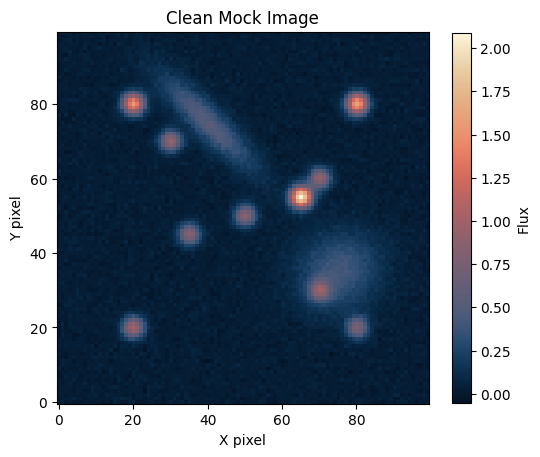

In [10]:
# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(image_clean, origin='lower', cmap=cmc.lipari)
plt.colorbar(label='Flux', shrink=0.8)
plt.title('Clean Mock Image')
plt.xlabel('X pixel')
plt.ylabel('Y pixel')

plt.show()

In [22]:
# Create cosmic ray mask
cosmicray_xpos = np.random.randint(0, 100, 10)
cosmicray_ypos = np.random.randint(0, 100, 10)


crmask_real = np.zeros(shape)
crmask_real[cosmicray_xpos, cosmicray_ypos] = 1.0

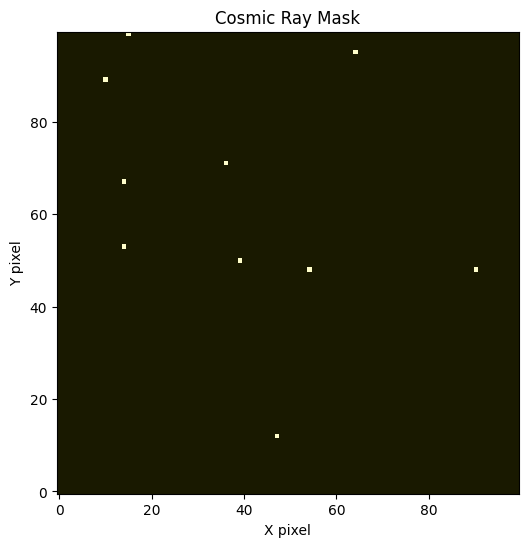

In [23]:
# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(crmask_real, origin='lower', cmap=cmc.lajolla)
plt.title('Cosmic Ray Mask')
plt.xlabel('X pixel')
plt.ylabel('Y pixel')

plt.show()

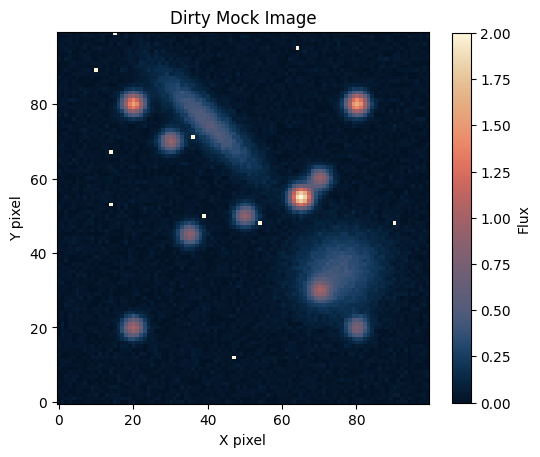

In [24]:
# Generate random values for each pixel
random_intensities = np.random.uniform(1, 100, crmask_real.shape)
# Apply only where cosmic rays exist
image_dirty = image_clean + random_intensities * crmask_real

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(image_dirty, origin='lower', cmap=cmc.lipari, vmin=0, vmax=2)
plt.colorbar(label='Flux', shrink=0.8)
plt.title('Dirty Mock Image')
plt.xlabel('X pixel')
plt.ylabel('Y pixel')

plt.show()

In [25]:
image_dfcosmic, crmask_dfcosmic = lacosmic(
    image = image_dirty.astype(np.float32), 
    objlim = 4,
    sigfrac = 0.5,
    sigclip = 4.5,
)

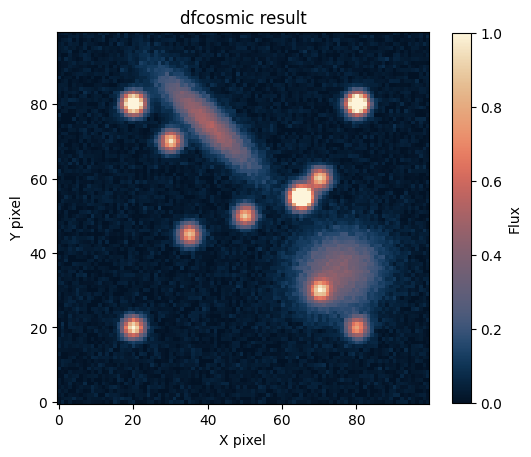

In [26]:
# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(image_dfcosmic, origin='lower', cmap=cmc.lipari, vmin=0, vmax=1)
plt.colorbar(label='Flux', shrink=0.8)
plt.title('dfcosmic result')
plt.xlabel('X pixel')
plt.ylabel('Y pixel')

plt.show()

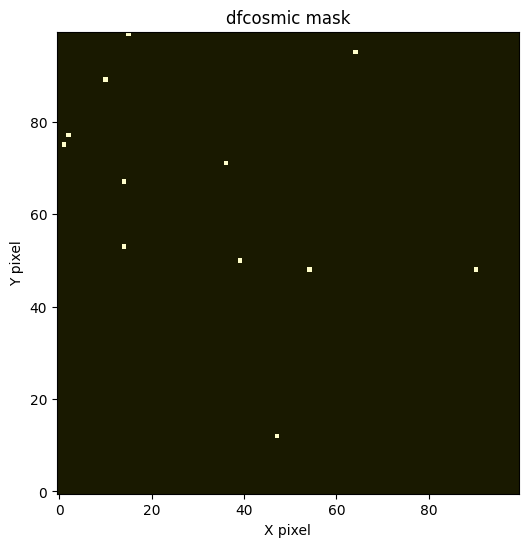

In [27]:
# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(crmask_dfcosmic, origin='lower', cmap=cmc.lajolla)
plt.title('dfcosmic mask')
plt.xlabel('X pixel')
plt.ylabel('Y pixel')

plt.show()

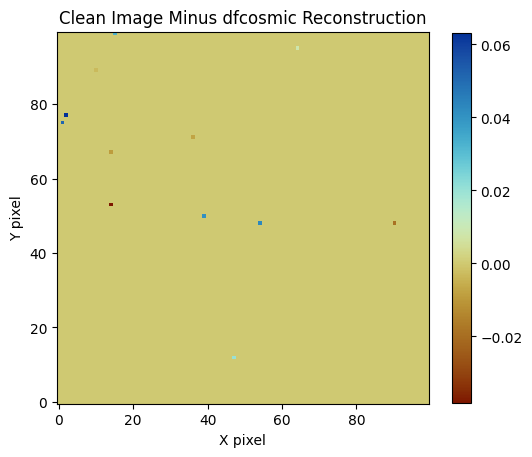

In [28]:
# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(image_clean - image_dfcosmic, origin='lower', cmap=cmc.roma)
plt.colorbar(shrink=0.8)
plt.title('Clean Image Minus dfcosmic Reconstruction')
plt.xlabel('X pixel')
plt.ylabel('Y pixel')

plt.show()

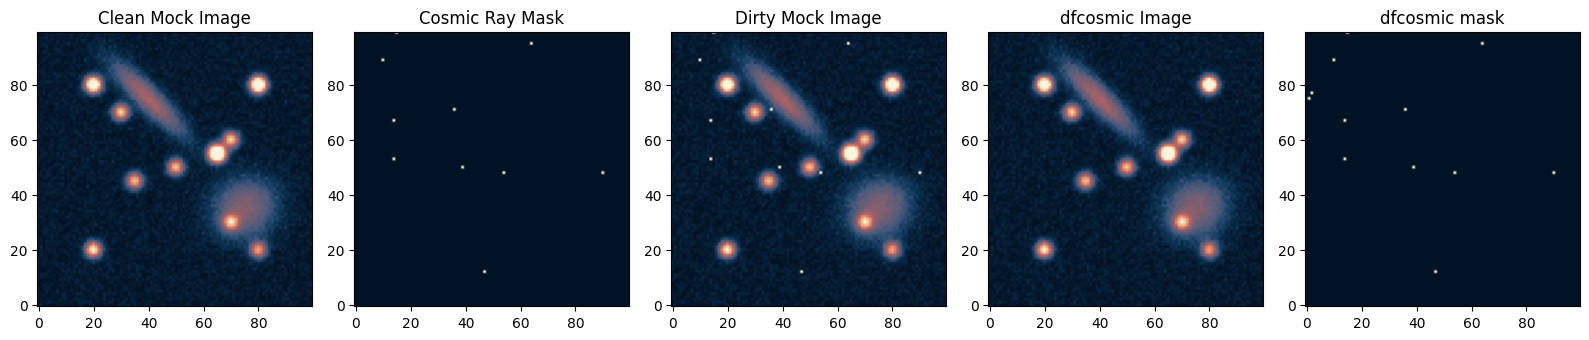

In [29]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(16, 4))

axes[0].imshow(image_clean, origin='lower', cmap=cmc.lipari, vmin=0, vmax=1)
axes[0].set_title('Clean Mock Image')

axes[1].imshow(crmask_real, origin='lower', cmap=cmc.lipari, vmin=0, vmax=1)
axes[1].set_title('Cosmic Ray Mask')


axes[2].imshow(image_dirty, origin='lower', cmap=cmc.lipari, vmin=0, vmax=1)
axes[2].set_title('Dirty Mock Image')

axes[3].imshow(image_dfcosmic, origin='lower', cmap=cmc.lipari, vmin=0, vmax=1)
axes[3].set_title('dfcosmic Image')


axes[4].imshow(crmask_dfcosmic, origin='lower', cmap=cmc.lipari, vmin=0, vmax=1)
axes[4].set_title('dfcosmic mask')

plt.tight_layout()
plt.savefig("./example.png", dpi=600)